DMS

In [116]:
from NMPC_solver import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
x_start = [ 0, 0.0, 0.0]
x_desired = [0.3, 0.4, 0.4]

In [118]:
Q = np.diag([120,
            100,
            100,
            1,
            1,
            1,
            1,
            7e-1,
            1.0,
            4.0,
            1e-2,
            1e-2,
            1e-2])
R = np.diag([1, 1, 1, 1])*0.1

solver_bounds = {"upper_pose_limit":[1, 1, 1.5],
                "lower_pose_limit":[-1, -1, 0],
                "upper_vel_limit":[2.5, 2.5, 2.5],
                "lower_vel_limit":[-2.5, -2.5, -2.5],
                "upper_att_limit": [inf]*4,#[1,1,1,1],
                "lower_att_limit":[-inf]*4,#[0,-1,-1,-1],
                "upper_ang_limit":[10, 10, 10],
                "lower_ang_limit":[-10, -10, -10],
                "u_min" : [ 0, 0, 0, 0],
                "u_max" : [ 22, 22, 22, 22]}

nlp_opts = {"ipopt": {"max_iter": 3000, "print_level" :0}, "jit": False, "print_time":0}
# nlp_opts = {"max_iter":1}
# nlp_opts = {"qpsol_options": {"max_iter":20}}
cost_type = "slack"      # use slack variables for the terminal cost          
# time for dms closed loop
dms_timing = { "frequency" : 50,         # sampling frequency
            # "solution_time" : 0.05,      # real world time to navigate the drone
            "N" : 5    ,   
            "DMS_RK4_step_size" : 2, # step size of RK4 method for DMS
            "degree" : 2}           # degree of the collocation polynomial  
# time for dc closed loop
dc_timing = { "frequency" : 50,         # sampling frequency
            "solution_time" : 0.1, 
            "N" : 5   , # real world time to navigate the drone
            "DMS_RK4_step_size" : 2, # step size of RK4 method for DMS
            "degree" : 3}       

min_deviation = 0.05

In [119]:
%autoreload
dms_open_loop = solver(dms_timing, solver_bounds, nlp_opts, Q, R )  # open loop by default
dc_open_loop = solver(dc_timing, solver_bounds, nlp_opts, Q, R, cost_type = False)


In [120]:
dms_open_loop.set_initial_values(x_start, x_desired)
dms_open_loop.create_dms_solver()
dms_open_loop.solve()
dms_open_loop._extract_solution()
print(dms_open_loop.deviation_list)

IPOPT status: Solve_Succeeded
[0.6403124237432849, 0.6399637821029662, 0.6389196432244599, 0.6376326537900954, 0.6367414994942201, 0.6364420841597946]


In [121]:
dc_open_loop.set_initial_values(x_start, x_desired)
# dc_open_loop.initial_state_guess = np.zeros((13,))
dc_open_loop.create_dc_solver()
dc_open_loop.solve()
dc_open_loop._extract_solution()


IPOPT status: Solve_Succeeded


In [122]:
dc_open_loop.solver_time

0.024641752243041992

In [123]:
#repeat the last element in dc_open_loop.deviation_list so that deviation_list_dc has lentght 50
deviation_list_dc = np.concatenate((np.array(dc_open_loop.deviation_list), np.array([dc_open_loop.deviation_list[-1]]*(50 - len(dc_open_loop.deviation_list)))))
                              
deviation_list_dms = np.concatenate((np.array(dms_open_loop.deviation_list), np.array([dms_open_loop.deviation_list[-1]]*(50 - len(dms_open_loop.deviation_list)))))
solver_time_dc = dc_open_loop.solver_time
solver_time_dms = dms_open_loop.solver_time

In [124]:
dms_timing["N"] = 50
dc_timing["N"] = dms_timing["N"]
dms_open_loop = solver(dms_timing, solver_bounds, nlp_opts, Q, R )  # open loop by default
dc_open_loop = solver(dc_timing, solver_bounds, nlp_opts, Q, R, cost_type = False)
dms_open_loop.set_initial_values(x_start, x_desired)
dms_open_loop.create_dms_solver()
dms_open_loop.solve()
dms_open_loop._extract_solution()
dc_open_loop.set_initial_values(x_start, x_desired)
# dc_open_loop.initial_state_guess = np.zeros((13,))
dc_open_loop.create_dc_solver()
dc_open_loop.solve()
dc_open_loop._extract_solution()
deviation_list_dc = np.vstack((deviation_list_dc, np.array(dc_open_loop.deviation_list)))
deviation_list_dms = np.vstack((deviation_list_dms, np.array(dms_open_loop.deviation_list)))
solver_time_dc = np.vstack((solver_time_dc, dc_open_loop.solver_time))
solver_time_dms = np.vstack((solver_time_dms, dms_open_loop.solver_time))


IPOPT status: Solve_Succeeded


SystemError: <built-in function Function_call> returned a result with an error set

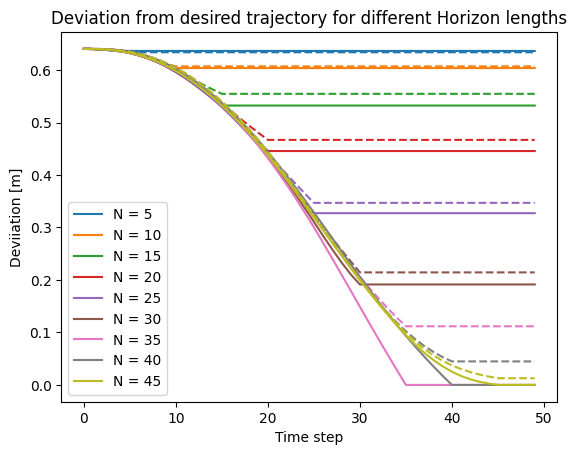

In [ ]:
#plot each row of deviation_list_dms as a line and deviation_list_dc as a dashed line, with each row of both lists colored the same. The label for each row is the N= 5 * (i+1)
# the color for each row is the same as the color for the corresponding row in the other list
plt.figure()
for i in range(len(deviation_list_dms)):
    plt.plot(deviation_list_dms[i], label = "N = {}".format(5*(i+1)), color = "C{}".format(i))
    plt.plot(deviation_list_dc[i], linestyle = "--", color = "C{}".format(i))
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Deviiation [m]")
plt.title("Deviation from desired trajectory for different Horizon lengths")
plt.savefig("N_vs_deviation.png")


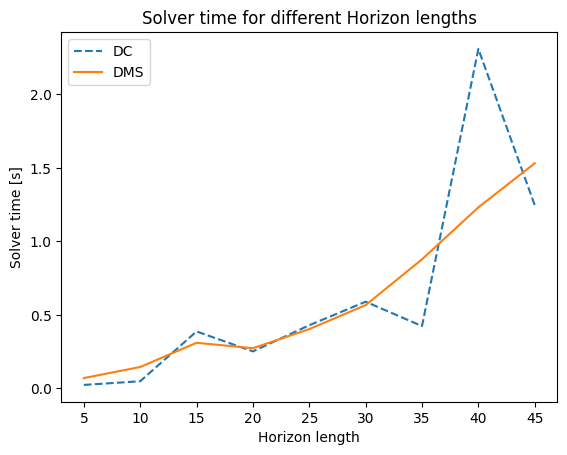

In [ ]:
# plot the graph of solver_time_dc against solver_time_dms for a range 5 t0 45 with step 5.
#solver_time_dc is a dashed line, whereas solver_time_dms is a solid line
plt.figure()
plt.plot(np.arange(5, 50, 5), solver_time_dc, linestyle = "--", label = "DC")
plt.plot(np.arange(5, 50, 5), solver_time_dms, label = "DMS")
plt.legend()
plt.xlabel("Horizon length")
plt.ylabel("Solver time [s]")
plt.title("Solver time for different Horizon lengths")
plt.savefig("N_vs_solver_time.png")


In [ ]:
time_step_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5,0.75, 1]
time_step_dev_list_dc = []
time_step_dev_list_dms = []
time_step_sol_time_dms =  []
time_step_sol_time_dc = []

In [ ]:

for time_step in time_step_list:
    dms_timing["N"] = 20
    dc_timing["N"] = dms_timing["N"]
    dms_open_loop = solver(dms_timing, solver_bounds, nlp_opts, Q, R,time_step=time_step )  # open loop by default
    dc_open_loop = solver(dc_timing, solver_bounds, nlp_opts, Q, R, cost_type = False, time_step=time_step)
    dms_open_loop.set_initial_values(x_start, x_desired)
    dms_open_loop.create_dms_solver()
    print("solver_created")
    dms_open_loop.solve()
    dms_open_loop._extract_solution()
    dc_open_loop.set_initial_values(x_start, x_desired)
    # dc_open_loop.initial_state_guess = np.zeros((13,))
    dc_open_loop.create_dc_solver()
    dc_open_loop.solve()
    print("dc solved")
    dc_open_loop._extract_solution()
    time_step_dev_list_dc.append(dc_open_loop.deviation_list[-1])
    time_step_dev_list_dms.append(dms_open_loop.deviation_list[-1])
    time_step_sol_time_dms.append(dms_open_loop.solver_time)
    time_step_sol_time_dc.append(dc_open_loop.solver_time)


solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved
solver_created
IPOPT status: Solve_Succeeded
IPOPT status: Solve_Succeeded
dc solved


In [ ]:
# time_step_list as the x-axis, scatterplot time_step_sol_time_dms and time_step_sol_time_dc as the y-axis, with each point colored the same as the corresponding point in time_step_sol_time_dms

time_step_sol_time_dc

[0.26749610900878906,
 1.5722784996032715,
 0.5002231597900391,
 0.9527623653411865,
 0.736792802810669,
 2.102489948272705,
 2.8508236408233643,
 2.987398862838745]

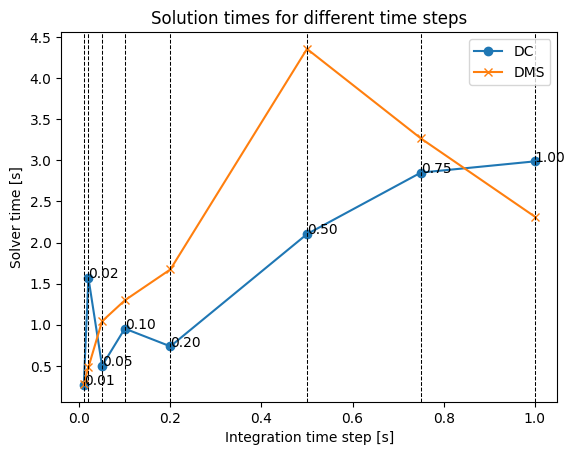

In [131]:
#plot a log graph of time_stp_list as x-asis and time_step_sol_time_dms and time_step_sol_time_dc as y-axis, with time_step_sol_time_dc as a dashed line and time_step_sol_time_dms as a solid line
plt.figure()
plt.plot(time_step_list, time_step_sol_time_dc, '-o', label = "DC")
plt.plot(time_step_list, time_step_sol_time_dms,'-x', label = "DMS")
#draw the x-intercept to the x_axis to each point with the same color and show the x-coordinate of the point
for i in range(len(time_step_list)):
    plt.axvline(x=time_step_list[i], ymin=0, ymax=4.5, color = "black", linestyle = "--", linewidth = 0.75)
    plt.text(time_step_list[i], time_step_sol_time_dc[i], "{:.2f}".format(time_step_list[i]))

plt.legend()

plt.xlabel("Integration time step [s]")
plt.ylabel("Solver time [s]")
plt.title("Solution times for different time steps")
plt.savefig("time_step_vs_solver_time_n_20.png")



In [258]:
from NMPC_solver import *
%load_ext autoreload
%autoreload
x_start = [0, 0, 0]
x_desired = [-0.5,0.5, 0.5]
Q_dms = Q_dc = np.diag([120,
            100,
            100,
            1e-2,
            1e-2,
            1e-2,
            1e-2,
            7e-1,
            1.0,
            4.0,
            1e-1,
            1e-1,
            1e-1])
Q_dc = np.diag([120,
            100,
            100,
            1e-2,
            1e-2,
            1e-2,
            1e-2,
            7e-1,
            1.0,
            4.0,
            1,
            1,
            1])
R = np.diag([1, 1, 1, 1])*0.06

solver_bounds = {"upper_pose_limit":[1, 1, 1.5],
                "lower_pose_limit":[-1, -1, 0],
                "upper_vel_limit":[2.5, 2.5, 2.5],
                "lower_vel_limit":[-2.5, -2.5, -2.5],
                "upper_att_limit": [inf]*4,#[1,1,1,1],
                "lower_att_limit":[-inf]*4,#[0,-1,-1,-1],
                "upper_ang_limit":[10, 10, 10],
                "lower_ang_limit":[-10, -10, -10],
                "u_min" : [ 0, 0, 0, 0],
                "u_max" : [ 22, 22, 22, 22]}

nlp_opts = {"ipopt": {"max_iter": 3000, "print_level" :0}, "jit": False, "print_time":0}
# nlp_opts = {"max_iter":1}
# nlp_opts = {"qpsol_options": {"max_iter":20}}
cost_type = "slack"      # use slack variables for the terminal cost          
# time for dms closed loop
dms_timing = { "frequency" : 50,         # sampling frequency
            # "solution_time" : 0.05,      # real world time to navigate the drone
            "N" : 20    ,   
            "DMS_RK4_step_size" : 2, # step size of RK4 method for DMS
            "degree" : 2}           # degree of the collocation polynomial  
# time for dc closed loop
dc_timing = { "frequency" : 50,         # sampling frequency
            "solution_time" : 0.1, 
            "N" : 20   , # real world time to navigate the drone
            "DMS_RK4_step_size" : 2, # step size of RK4 method for DMS
            "degree" : 2}       
time_step_dc =  0.1
time_step_dms = 0.01
min_deviation = 0.01
dms_closed_loop = solver(dms_timing, solver_bounds, nlp_opts, Q_dms, R, time_step=time_step_dms,cost_type=False, simulation_type = None) 
dc_closed_loop = solver(dc_timing, solver_bounds, nlp_opts, Q_dc, R, time_step=time_step_dc,cost_type = False, simulation_type = None,use_shift=False)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IPOPT status: Solve_Succeeded
time for solver in step  2  is  0.23385906219482422
time for step  2  is  0.23429441452026367
IPOPT status: Solve_Succeeded
time for solver in step  3  is  0.24636054039001465
time for step  3  is  0.2468888759613037
IPOPT status: Solve_Succeeded
time for solver in step  4  is  0.2830972671508789
time for step  4  is  0.2834467887878418
IPOPT status: Solve_Succeeded
time for solver in step  5  is  0.22981047630310059
time for step  5  is  0.23022222518920898
IPOPT status: Solve_Succeeded
time for solver in step  6  is  0.24696087837219238
time for step  6  is  0.24732255935668945
IPOPT status: Solve_Succeeded
time for solver in step  7  is  0.24843502044677734
time for step  7  is  0.24878168106079102
IPOPT status: Solve_Succeeded
time for solver in step  8  is  0.22234535217285156
time for step  8  is  0.22286009788513184
IPOPT status: Solve_Succeeded
time for solver in step  9  is  0.21133852005004883
time for step  9  is  0.21169328689575195
IPOPT statu

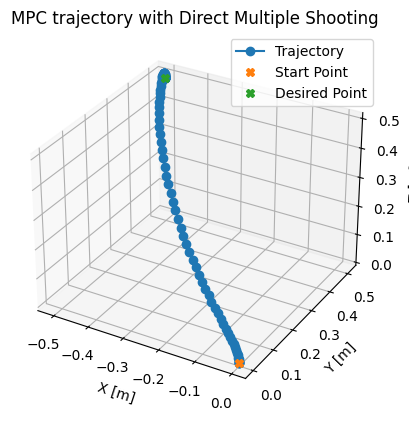

In [259]:
dms_closed_loop.set_initial_values(x_start, x_desired)
dms_closed_loop.create_dms_solver()
dms_closed_loop.run_mpc(100, min_deviation)
# print(dms_closed_loop.X_opt[:, :3])
# print(dms_closed_loop.U_opt)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dms_closed_loop.X_opt = np.round(dms_closed_loop.X_opt, 3)
ax.plot(dms_closed_loop.X_opt[:, 0], dms_closed_loop.X_opt[:, 1], dms_closed_loop.X_opt[:, 2], 'o-', label = "Trajectory")
ax.plot(x_start[0], x_start[1], x_start[2], 'X', label = "Start Point")
ax.plot(x_desired[0], x_desired[1], x_desired[2], 'X', label = "Desired Point")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.title("MPC trajectory with Direct Multiple Shooting")
plt.legend()
plt.savefig("dms_trajectory_n_20.png")




IPOPT status: Solve_Succeeded
time for solver in step  2  is  0.0751962661743164
time for step  2  is  0.07578229904174805
IPOPT status: Solve_Succeeded
time for solver in step  3  is  0.04807758331298828
time for step  3  is  0.04871702194213867
IPOPT status: Solve_Succeeded
time for solver in step  4  is  0.035784244537353516
time for step  4  is  0.036359548568725586
IPOPT status: Solve_Succeeded
time for solver in step  5  is  0.029326915740966797
time for step  5  is  0.029702186584472656
IPOPT status: Solve_Succeeded
time for solver in step  6  is  0.03003215789794922
time for step  6  is  0.030448198318481445
IPOPT status: Solve_Succeeded
time for solver in step  7  is  0.032746076583862305
time for step  7  is  0.033271074295043945
IPOPT status: Solve_Succeeded
time for solver in step  8  is  0.032536983489990234
time for step  8  is  0.032981157302856445
IPOPT status: Solve_Succeeded
time for solver in step  9  is  0.03378868103027344
time for step  9  is  0.03433489799499512


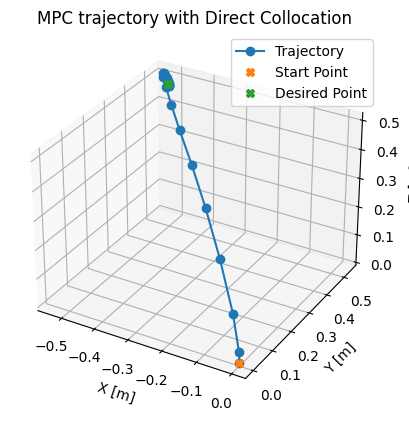

In [260]:
dc_closed_loop.set_initial_values(x_start, x_desired)
dc_closed_loop.create_dc_solver()
dc_closed_loop.run_mpc(100, min_deviation)
# print(dc_closed_loop.X_opt[:, :3])
dc_closed_loop.X_opt = np.round(dc_closed_loop.X_opt, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(dc_closed_loop.X_opt[:, 0], dc_closed_loop.X_opt[:, 1], dc_closed_loop.X_opt[:, 2], 'o-', label = "Trajectory")
ax.plot(x_start[0], x_start[1], x_start[2], 'X', label = "Start Point")
ax.plot(x_desired[0], x_desired[1], x_desired[2], 'X', label = "Desired Point")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.title("MPC trajectory with Direct Collocation")
plt.savefig("dc_trajectory_n_20.png")

In [261]:
dms_mpc_dev = np.concatenate([np.array(dms_closed_loop.deviation_list), np.array([dms_closed_loop.deviation_list[-1]]*(len(dc_closed_loop.deviation_list) - len(dms_closed_loop.deviation_list)))])
dc_mpc_dev = np.array(dc_closed_loop.deviation_list)

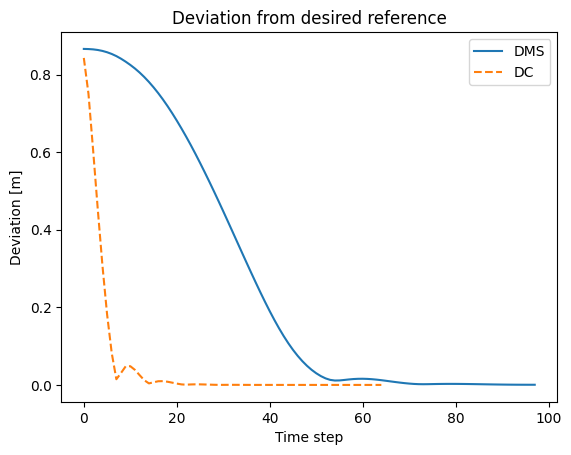

In [262]:
#plot the deviation of the drone from the desired trajectory for both methods
plt.plot(dms_mpc_dev, label = "DMS")
plt.plot(dc_mpc_dev, label = "DC", linestyle = "--")
plt.xlabel("Time step")
plt.ylabel("Deviation [m]")
plt.title("Deviation from desired reference")
plt.legend()
plt.savefig("mpc_deviation.png")


In [263]:
dc_closed_loop.U_opt.shape

(66, 4)

In [264]:
dms_closed_loop.U_opt.shape

(99, 4)

In [265]:
dms_control = np.array(dms_closed_loop.U_opt)
dc_control = np.array(dc_closed_loop.U_opt)

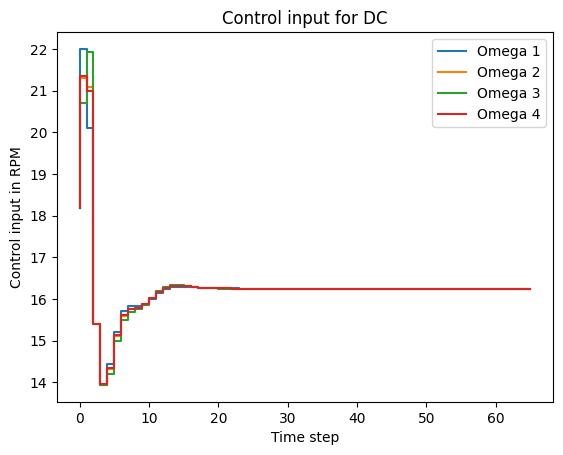

In [266]:
#plot dc_control as stairs
plt.step(np.arange(len(dc_control)), dc_control[:, 0], label = "Omega 1")
plt.step(np.arange(len(dc_control)), dc_control[:, 1], label = "Omega 2")
plt.step(np.arange(len(dc_control)), dc_control[:, 2], label = "Omega 3")
plt.step(np.arange(len(dc_control)), dc_control[:, 3], label = "Omega 4")
plt.xlabel("Time step")
plt.ylabel("Control input in RPM")
plt.title("Control input for DC")
plt.legend()
plt.savefig("dc_control.png")



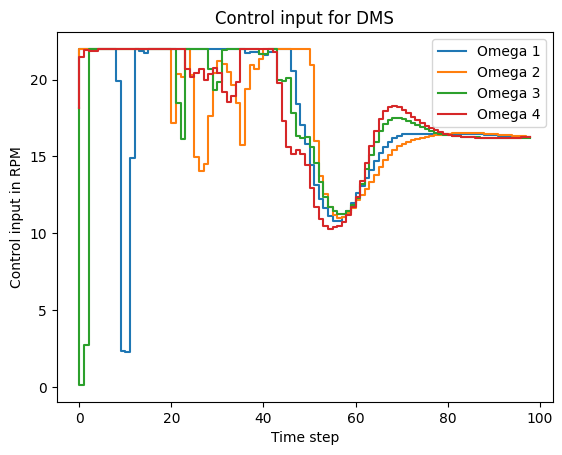

In [267]:
#plot dms_control as stairs
plt.step(np.arange(len(dms_control)), dms_control[:, 0], label = "Omega 1")
plt.step(np.arange(len(dms_control)), dms_control[:, 1], label = "Omega 2")
plt.step(np.arange(len(dms_control)), dms_control[:, 2], label = "Omega 3")
plt.step(np.arange(len(dms_control)), dms_control[:, 3], label = "Omega 4")
plt.xlabel("Time step")
plt.ylabel("Control input in RPM")
plt.title("Control input for DMS")
plt.legend()
plt.savefig("dms_control.png")


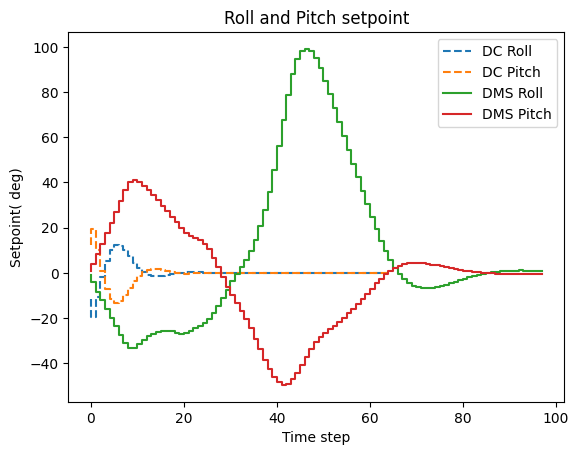

In [268]:


dms_control_list = np.array(dms_closed_loop.control_list)
dms_roll = dms_control_list[:, 0]
dms_pitch = dms_control_list[:, 1]
dms_yaw_rate = dms_control_list[:, 2]
dms_thrust = dms_control_list[:, 3]

dc_control_list = np.array(dc_closed_loop.control_list)
dc_roll = dc_control_list[:, 0]
dc_pitch = dc_control_list[:, 1]
dc_yaw_rate = dc_control_list[:, 2]
dc_thrust = dc_control_list[:, 3]
# plot dc_roll and dc_pitch as dashed stairs, dms_roll and dms_pitch as stairs
plt.step(np.arange(len(dc_roll)), dc_roll, label = "DC Roll", linestyle = "--")
plt.step(np.arange(len(dc_pitch)), dc_pitch, label = "DC Pitch", linestyle = "--")
plt.step(np.arange(len(dms_roll)), dms_roll, label = "DMS Roll")
plt.step(np.arange(len(dms_pitch)), dms_pitch, label = "DMS Pitch")
plt.xlabel("Time step")
plt.ylabel("Setpoint( deg)")
plt.title("Roll and Pitch setpoint")
plt.legend()
plt.savefig("roll_pitch_setpoint.png")


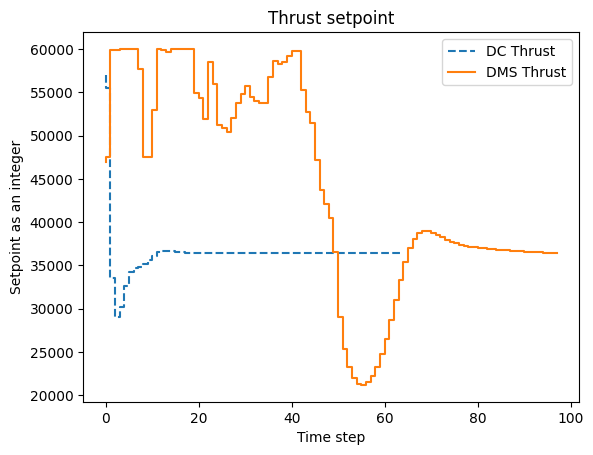

In [269]:
#plot thrust as stairs
plt.step(np.arange(len(dc_thrust)), dc_thrust, label = "DC Thrust", linestyle = "--")
plt.step(np.arange(len(dms_thrust)), dms_thrust, label = "DMS Thrust")
plt.xlabel("Time step")
plt.ylabel("Setpoint as an integer")
plt.title("Thrust setpoint")
plt.legend()
plt.savefig("thrust_setpoint.png")

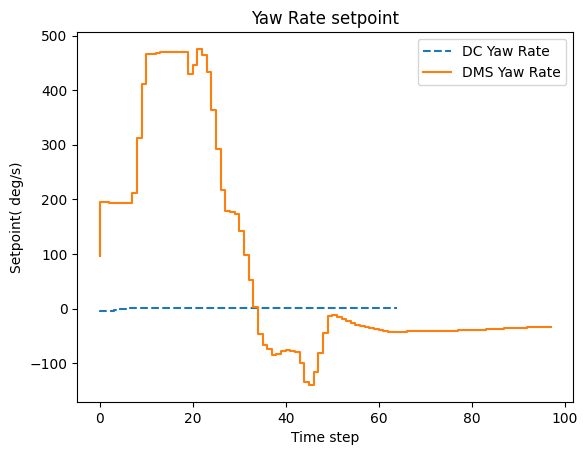

In [270]:
#plot yaw_rate as stairs
plt.step(np.arange(len(dc_yaw_rate)), dc_yaw_rate, label = "DC Yaw Rate", linestyle = "--")
plt.step(np.arange(len(dms_yaw_rate)), dms_yaw_rate, label = "DMS Yaw Rate")
plt.xlabel("Time step")
plt.ylabel("Setpoint( deg/s)")
plt.title("Yaw Rate setpoint")
plt.legend()
plt.savefig("yaw_rate_setpoint.png")
